<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#MVPCorrelation" data-toc-modified-id="MVPCorrelation-1">MVPCorrelation</a></span></li><li><span><a href="#Create-simulated-dataset" data-toc-modified-id="Create-simulated-dataset-2">Create simulated dataset</a></span></li><li><span><a href="#Load-post-processed-simulated-data" data-toc-modified-id="Load-post-processed-simulated-data-3">Load post-processed simulated data</a></span></li><li><span><a href="#Visualize-our-data" data-toc-modified-id="Visualize-our-data-4">Visualize our data</a></span><ul class="toc-item"><li><span><a href="#Correlation-approach" data-toc-modified-id="Correlation-approach-4.1">Correlation approach</a></span></li><li><span><a href="#Classifier-apprach" data-toc-modified-id="Classifier-apprach-4.2">Classifier apprach</a></span></li></ul></li><li><span><a href="#Perform-group-level-analysis" data-toc-modified-id="Perform-group-level-analysis-5">Perform group-level analysis</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6">Conclusion</a></span></li></ul></div>

# MVPCorrelation

# Create simulated dataset

In [355]:
## Code for simulating the data: ##
import pymc3 as pm
np.random.seed(1)
num_subjects = 20
num_conditions = 2
num_blocks = 40
num_voxels = 50
data=[]

activations=np.full(num_subjects*num_blocks*num_voxels,np.nan)
sub_id=np.full(num_subjects*num_blocks*num_voxels,np.nan)
cond_id=np.full(num_subjects*num_blocks*num_voxels,np.nan)
block_id=np.full(num_subjects*num_blocks*num_voxels,np.nan)
vox_id=np.full(num_subjects*num_blocks*num_voxels,np.nan)

from scipy import signal
def make_noncirc_gaussian_iter(mu,sd,stim_max=360):
    if np.isscalar(mu):
        mu=[mu]
    if np.isscalar(sd):
        sd=[sd]
    return np.array([sp.stats.norm.pdf(np.arange(stim_max), m, s)
                         for m,s in zip(mu,sd)]).T
# create voxel tuning functions per condition
vox_tuning = np.full((num_voxels,5),np.nan)
for v in range(num_voxels):
    if np.random.randint(2)==0:
        vox_tuning[v,:] = make_noncirc_gaussian_iter([.5+np.random.rand()/2],[np.random.rand()+1],5).flatten()
    else:
        vox_tuning[v,:] = make_noncirc_gaussian_iter([2.5+np.random.rand()/2],[np.random.rand()+1],5).flatten()

cnt=0
blocks=np.concatenate([np.zeros(num_blocks//2),np.ones(num_blocks//2)])
for s in range(num_subjects):
    for r in range(num_blocks):
        c=blocks[r]
        if c==0:
            for v in range(num_voxels):
                activations[cnt]=vox_tuning[v,1]+np.random.rand()/2
                vox_id[cnt]=v
                sub_id[cnt]=s
                cond_id[cnt]=c
                block_id[cnt]=r
                cnt+=1
        else:
            for v in range(num_voxels):
                activations[cnt]=vox_tuning[v,3]+np.random.rand()/2
                vox_id[cnt]=v
                sub_id[cnt]=s
                cond_id[cnt]=c
                block_id[cnt]=r
                cnt+=1

np.save('activations.npy',activations)
np.save('sub_id.npy',sub_id)
np.save('cond_id.npy',cond_id)
np.save('block_id.npy',block_id)
np.save('vox_id.npy',vox_id)

# Load post-processed simulated data
Import our data. Look at how many subjects, trial conditions, and voxels we have to work with. 

Note that we follow Python conventions by numbering variables starting at 0 and not 1.

In [84]:
# general packages
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from sklearn import svm

# pull data from GitHub
import requests, io
for array in ['activations','sub_id','cond_id','block_id']:
    globals()['{}'.format(array)] = np.load(io.BytesIO(requests.get(
        'http://paulscotti.github.io/navigateFMRI/methods/mvpa/{}.npy'.format(array)).content))

# overview of the data
num_subjects = len(np.unique(sub_id)) #20
num_conditions = len(np.unique(cond_id)) #2
num_blocks = len(np.unique(block_id)) #40

In [359]:
# change default plotting
plt.rcParams.update({'font.size': 20, 'figure.figsize': (7,2)})

# Visualize our data

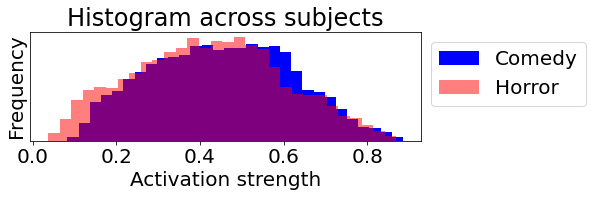

In [357]:
plt.hist(activations[cond_id==0],color='blue',bins=30,label='Comedy')
plt.hist(activations[cond_id==1],color='red',bins=30,alpha=.5,label='Horror')
plt.yticks([]);plt.ylabel('Frequency')
plt.xlabel("Activation strength")
plt.legend(bbox_to_anchor=(1, 1))
plt.title("Histogram across subjects")
plt.show()

## Correlation approach

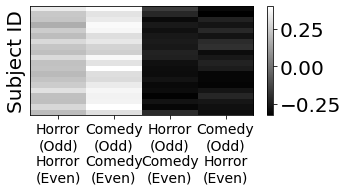

From left to right:
° cond0 (odd) & cond0 (even)     Avg. across subjects:  r=0.2428
° cond1 (odd) & cond1 (even)     Avg. across subjects:  r=0.3411
° cond0 (odd) & cond1 (even)     Avg. across subjects:  r=-0.2605
° cond1 (odd) & cond0 (even)     Avg. across subjects:  r=-0.2612

Significantly different correlations betw first two columns and last two columns? (paired t-test):
t=48.5594, p=0.0000


In [358]:
# for each subject, correlate odd/even runs for each condition
corr = np.full((num_subjects,num_conditions*2),np.nan)
for s in range(num_subjects):
    for c in range(num_conditions*2):
        if c == 0: # cond0 (odd) -> cond0 (even)
            corr[s,c], _ = sp.stats.pearsonr(activations[(sub_id==s)&(cond_id==0)&(block_id%2==1)],
                                            activations[(sub_id==s)&(cond_id==0)&(block_id%2==0)])
        elif c == 1: # cond1 (odd) -> cond1 (even)
            corr[s,c], _ = sp.stats.pearsonr(activations[(sub_id==s)&(cond_id==1)&(block_id%2==1)],
                                            activations[(sub_id==s)&(cond_id==1)&(block_id%2==0)])
        elif c == 2: # cond0 (odd) -> cond1 (even)
            corr[s,c], _ = sp.stats.pearsonr(activations[(sub_id==s)&(cond_id==0)&(block_id%2==1)],
                                            activations[(sub_id==s)&(cond_id==1)&(block_id%2==0)])
        elif c == 3: # cond1 (odd) -> cond0 (even)
            corr[s,c], _ = sp.stats.pearsonr(activations[(sub_id==s)&(cond_id==1)&(block_id%2==1)],
                                            activations[(sub_id==s)&(cond_id==0)&(block_id%2==0)])
# corr=np.abs(corr)
    
with plt.rc_context(rc={'font.size': 20, 'figure.figsize': (5,2)}):
    plt.imshow(corr, cmap='gray', aspect='auto')
    plt.ylabel('Subject ID')
    plt.yticks([]);
    plt.xticks(np.arange(4),["Horror\n(Odd)\nHorror\n(Even)","Comedy\n(Odd)\nComedy\n(Even)",
                             "Horror\n(Odd)\nComedy\n(Even)","Comedy\n(Odd)\nHorror\n(Even)"],
               fontsize=14, rotation=0, ha="center")
#     plt.xlabel('Correlation Condition')
    plt.colorbar()
    plt.show()

print('From left to right:')
print('° cond0 (odd) & cond0 (even)     Avg. across subjects:  r={:.4f}'.format(np.mean(corr[:,0])))
print('° cond1 (odd) & cond1 (even)     Avg. across subjects:  r={:.4f}'.format(np.mean(corr[:,1])))
print('° cond0 (odd) & cond1 (even)     Avg. across subjects:  r={:.4f}'.format(np.mean(corr[:,2])))
print('° cond1 (odd) & cond0 (even)     Avg. across subjects:  r={:.4f}'.format(np.mean(corr[:,3])))

stat = sp.stats.ttest_rel(corr[:,:2].flatten(),corr[:,2:].flatten())
print("\nSignificantly different correlations betw first two columns and last two columns? (paired t-test):\nt={:.4f}, p={:.4f}".format(stat.statistic,stat.pvalue))